In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme('paper',style='white',font_scale=1.25)
import math
import random
import matplotlib
from os.path import join,exists
import os
from os import mkdir
import cv2

This jupyter noteboook should support article: Magnetic microrheometry of tumor-relevant stiffness levels and heterogeneity in viscoelasticity inside 3D cell culture matrices

- You can use this to reproduce all figures shown in the article after downloading data:

data is available from [dropbox](https://www.dropbox.com/sh/uw8l7ne84guyrfg/AAATW3DDnIwKkotkmr9UX6KSa?dl=0)

Link: https://www.dropbox.com/sh/uw8l7ne84guyrfg/AAATW3DDnIwKkotkmr9UX6KSa?dl=0


-Microrheology data can be found from material spesifc .csv inside "microdata"
-Macrorheology data can be found from material spsific .csv inside "macrodata"

In [6]:
#change this to correspond the folder you downloaded data
data_folder = "C:/Users/lehtona6/Dropbox (Aalto)/ArttuFolder_PokkiLab/Shared_Materials/ExampleData"


######
#Micro
######


#Calibration
Calib_100 = pd.read_csv(os.path.join(data_folder,"microdata/Calibration_100_track_ID_summary.csv"))
Calib_30 = pd.read_csv(os.path.join(data_folder,"microdata/Calibration_30_track_ID_summary.csv"))
Calib_100["loss_tan"] = np.tan(Calib_100["phi_(rad)"])
Calib_30["loss_tan"] = np.tan(Calib_30["phi_(rad)"]) 

#100µm Agarose
Agarose = pd.read_csv(os.path.join(data_folder,"microdata/Agarose_100_track_ID_summary.csv"))

#30µm Agarose
low_Agarose = pd.read_csv(os.path.join(data_folder,"microdata/Agarose_30_track_ID_summary.csv"))

#GD-Col
GD_COL = pd.read_csv(os.path.join(data_folder,"microdata/GrowDex-Collagen_track_ID_summary.csv"))

#GD
GD = pd.read_csv(os.path.join(data_folder,"microdata/GrowDex_track_ID_summary.csv"))

#Fibrin
Fibrin = pd.read_csv(os.path.join(data_folder,"microdata/Fibrin_track_ID_summary.csv"))

#Heterogenity esitmation data frame
hetero_gen = pd.concat([GD,GD_COL,Fibrin,low_Agarose])
hetero_gen = hetero_gen[(hetero_gen["concentration"] == 1.25) | (hetero_gen["concentration"] == "0.45/2") | (hetero_gen["concentration"] == 30) | (hetero_gen["type"] == "Agarose")]

######
# Macro
######

#Agarose
M_Ag = pd.read_csv(os.path.join(data_folder,"macrodata/Agarose_100_Macrorheology.csv"))
M_Ag = M_Ag[M_Ag["particle_condition"] == 1]
M_Ag = M_Ag.rename(columns={'concentration':'concentration %',
                              'Complex Shear Modulus':'Complex Shear Modulus (Pa)',
                              'Time':'Time (min)',
                              'Phase Shift Angle': 'Phase Shift Angle (Pa)'})
M_Ag["concentration %"] = round(M_Ag["concentration %"]*10,2)
M_Ag.loc[M_Ag["concentration %"] == 1.2,"concentration %"] = 1.25
M_Ag.loc[M_Ag["concentration %"] == 1.3,"concentration %"] = 1.35

# GD
M_GD = pd.read_csv(os.path.join(data_folder,"macrodata/Growdex_Macrorheology.csv"))
M_GD = M_GD[M_GD["concentration"] == 1.25]
M_GD = M_GD.rename(columns={'concentration':'concentration %',
                              'Complex Shear Modulus':'Complex Shear Modulus (Pa)',
                              'Time':'Time (min)',
                              'Phase Shift Angle': 'Phase Shift Angle (Pa)'})

# GD-Col
M_GD_col = pd.read_csv(os.path.join(data_folder,"macrodata/Growdex_collagen_Macrorheology.csv"))
M_GD_col = M_GD_col[M_GD_col["concentration"] == 0.45]
M_GD_col = M_GD_col.rename(columns={'concentration':'concentration %',
                              'Complex Shear Modulus':'Complex Shear Modulus (Pa)',
                              'Time':'Time (min)',
                              'Phase Shift Angle': 'Phase Shift Angle (Pa)'})


In [7]:

#Saves the plot
def saver(fig,name):
    data_folder = "C:/Users/lehtona6/projects/work/microrheology/visualization"
    res_path = join(data_folder,"results/" + name)
    fig.savefig(res_path,transparent=False,facecolor='white' )

#plots micro
def plotter(data_in,x_data,y_data,x_label,y_label,ax_in,letter,scientific = False,ylim=False):
    sns.swarmplot(ax = ax_in,x=x_data,y=y_data,data=data_in,size=5,color='black',alpha=0.5)
    sns.boxplot(ax = ax_in,x=x_data,y=y_data,data=data_in,color = "white", showmeans = True,meanprops={
                        "marker":"s",
                        "markerfacecolor":"red", 
                        "markeredgecolor":"red",
                        "markersize":"7",
                        "alpha":1.0})
    ax_in.set_xlabel(x_label, fontsize=12)
    ax_in.set_ylabel(y_label, fontsize=12)
    ax_in.text(-0.1, 1.15, letter, transform=ax_in.transAxes,fontsize=24, fontweight='bold', va='top', ha='right')
    ax_in.tick_params(labelsize=9)
    if scientific:    
        ax_in.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        ax_in.yaxis.major.formatter._useMathText = True
    if ylim:
        ax_in.set_ylim(ylim)
    return ax_in  



#plots macro |G|
def plot_macro_g(data,ax_in,letter,x_label,y_label,vline=True,log=True):
    sns.lineplot(ax = ax_in, data=data,x='Time (min)',y='Complex Shear Modulus (Pa)',hue='concentration %',
                palette=sns.color_palette('bright',data['concentration %'].unique().shape[0]), legend = False)
    ax_in.text(-0.09, 1.15, letter, transform=ax_in.transAxes,fontsize=24, fontweight='bold', va='top', ha='right')
    ax_in.set_xlabel(x_label, fontsize=12)
    ax_in.set_ylabel(y_label, fontsize=12)
    ax_in.tick_params(labelsize=9)
    if vline:
        ax_in.axvline(50,color='black',linestyle='--')
    if log:
        #ax.set_yscale('log')
        ax_in.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax_in.ticklabel_format(axis='y',style='sci', scilimits=(0,0))
        ax_in.yaxis.major.formatter._useMathText = True
        #ax_in.legend(title = r"Concentration [$\%$]",loc='upper left',fontsize = 9)
        #ax_in.legend()

    return ax_in

#plots macro phi
def plot_macro_phi(data,ax_in,letter,x_label,y_label,vline=True,log=False,ae=True):
    sns.lineplot(ax = ax_in, data=data,x='Time (min)',y='Phase Shift Angle (Pa)',hue='concentration %',
                palette=sns.color_palette('bright',data['concentration %'].unique().shape[0]))
    ax_in.text(-0.1, 1.15, letter, transform=ax_in.transAxes,fontsize=24, fontweight='bold', va='top', ha='right')
    ax_in.set_xlabel(x_label, fontsize=12)
    ax_in.set_ylabel(y_label, fontsize=12)
    ax_in.tick_params(labelsize=9)
    ax_in.set_xlim([0,90])
    if vline:
        ax_in.axvline(50,color='black',linestyle='--')
    if log:
        ax_in.set_yscale('log')
        ax_in.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax_in.ticklabel_format(axis='y',style='plain', scilimits=(0,0))
        ax_in.yaxis.major.formatter._useMathText = True
        ax_in.legend(title = r"Concentration [$\%$]",loc='upper left',fontsize = 9)
    if ae:
        plt.ylim([0,10])
        
    return ax_in

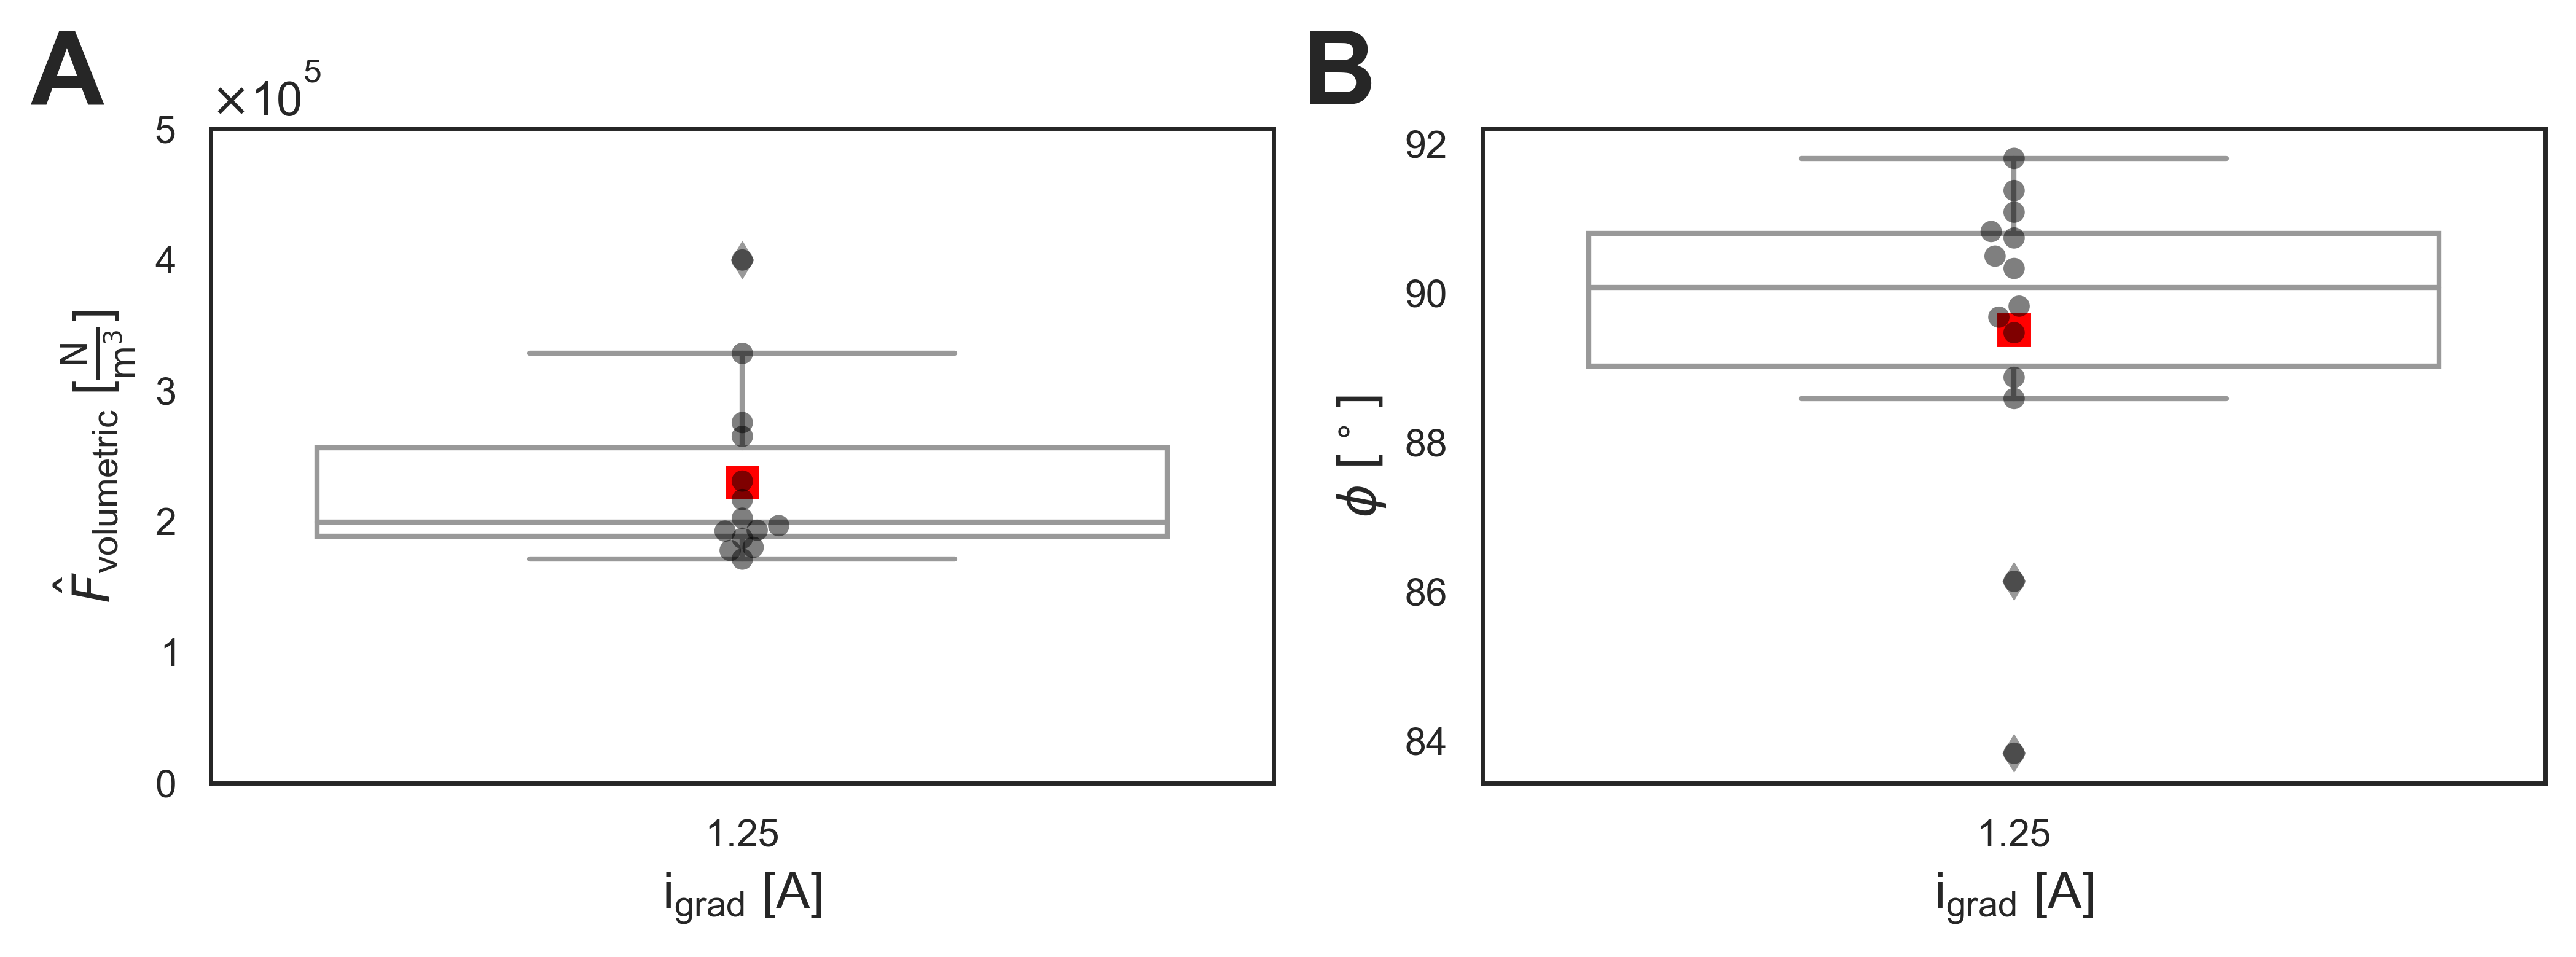

               F_V_fit                phi_(deg)          
                  mean           std       mean       std
current                                                  
1.25     229700.992161  66259.348224  89.498043  2.168311


<ipython-input-8-ffe4268cd233>:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print(Calib_100.groupby("current")["F_V_fit","phi_(deg)"].agg(["mean","std"]))


In [8]:
# Plot Calibration 100 µm

fig = plt.figure(constrained_layout=True, figsize=(8.27, 3),dpi = 500)
subfigs = fig.subfigures(1, 2, wspace=0.0025, width_ratios=[1, 1])

ax1 = subfigs[0].subplots(1, 1)
ax2 = subfigs[1].subplots(1, 1)

ax1 = plotter(Calib_100, "current", "F_V_fit",r"i$_\mathregular{grad}$ [A]",r"$\hat{F}_\mathregular{volumetric}$ [$\frac{\rm{N}}{\rm{m}^3}$]",ax1,"A",True,[0,500000])
ax2 = plotter(Calib_100, "current", "phi_(deg)",r"i$_\mathregular{grad}$ [A]",r"$\phi$ $[^\circ]$",ax2,"B")

#fig.tight_layout()
saver(fig,"100um_calibration.png")

plt.show()

#print averages and std in a table
print(Calib_100.groupby("current")["F_V_fit","phi_(deg)"].agg(["mean","std"]))

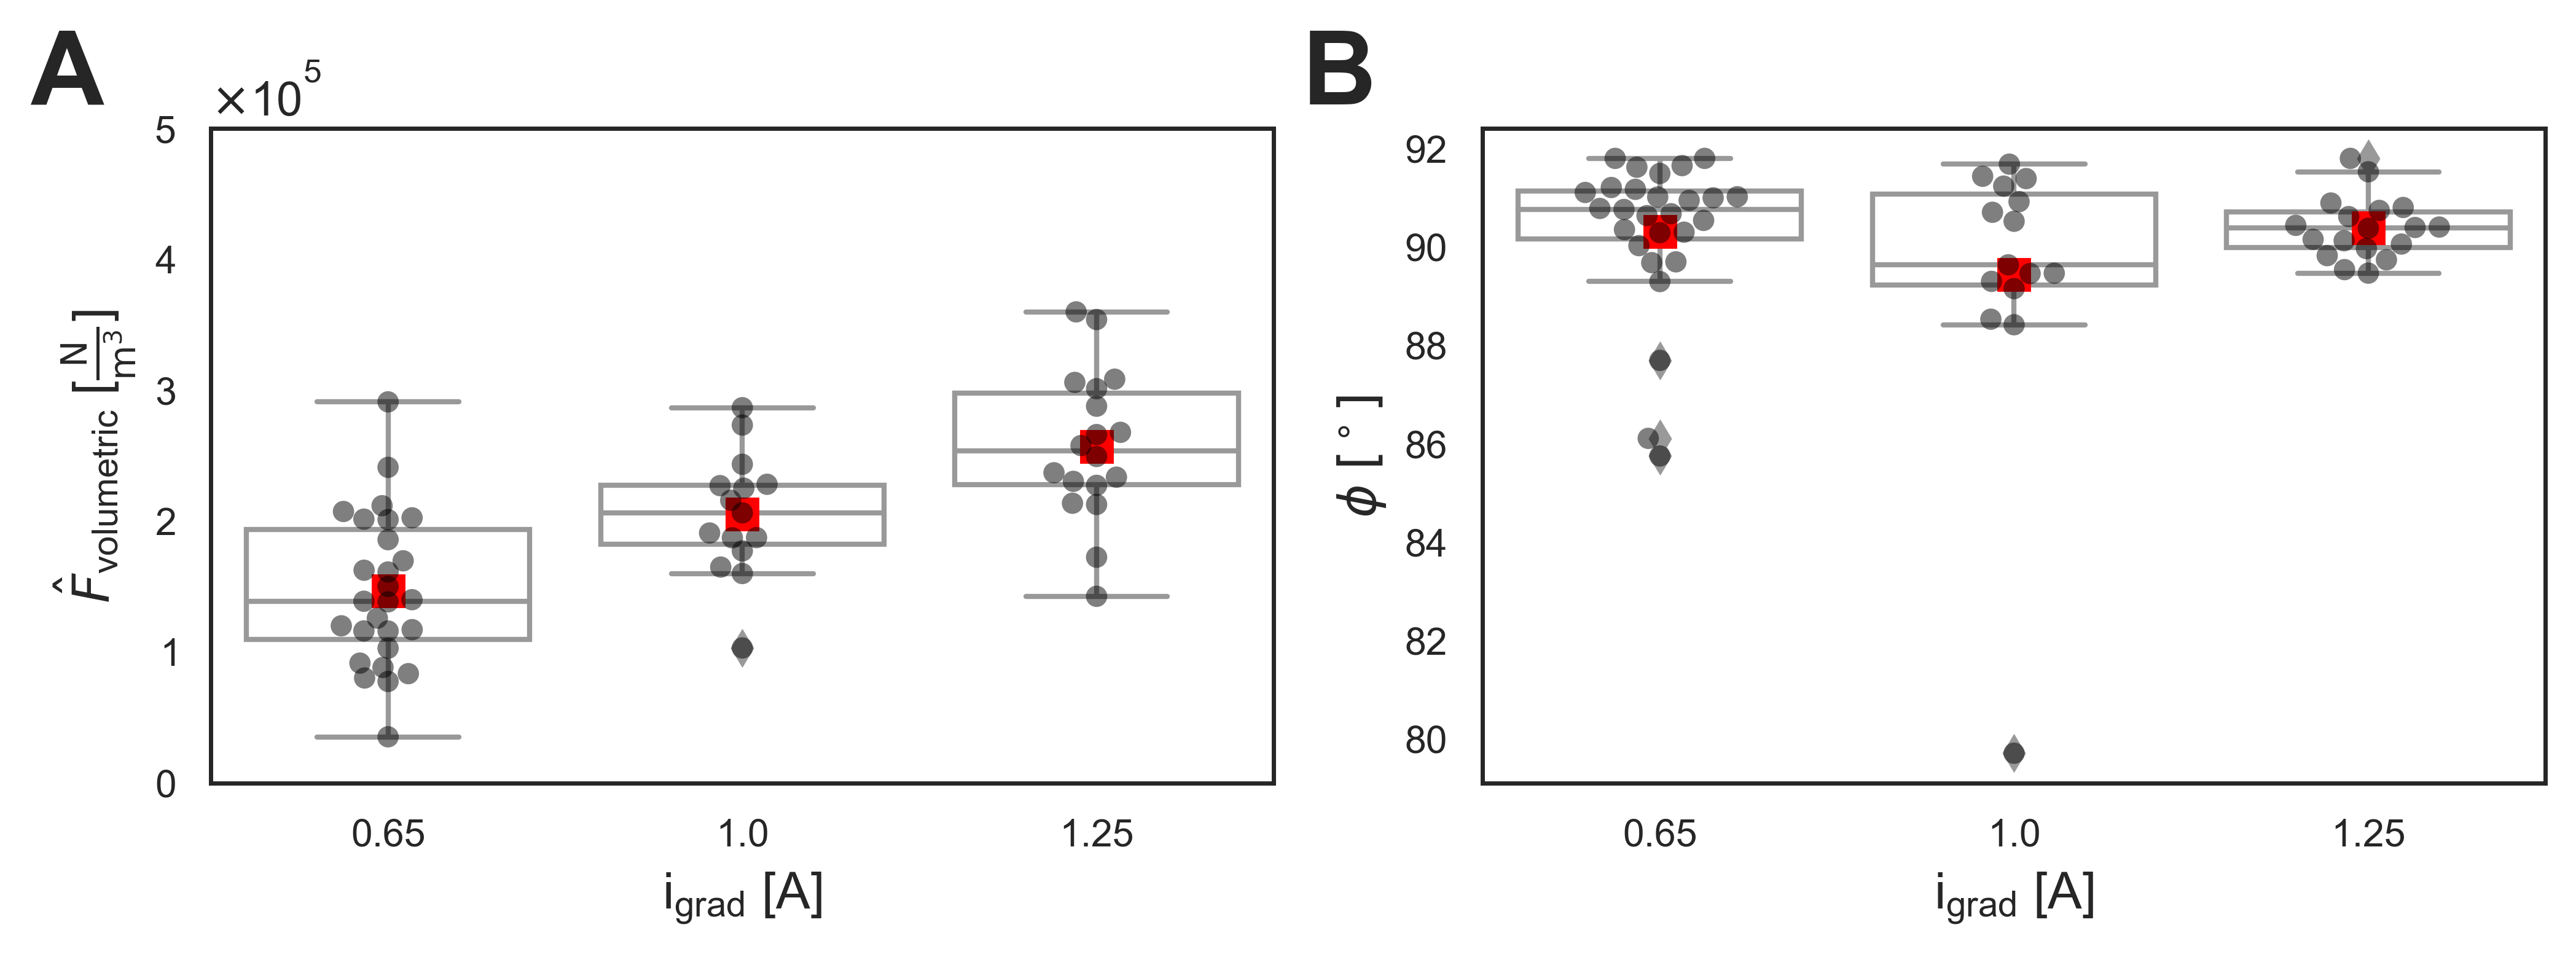

               F_V_fit                phi_(deg)          
                  mean           std       mean       std
current                                                  
0.65     146633.470887  57991.282918  90.311294  1.536187
1.00     205220.301502  46284.796237  89.436593  2.901044
1.25     257210.595497  56800.823047  90.381145  0.624153


<ipython-input-9-793f2377d6aa>:16: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print(Calib_30.groupby("current")["F_V_fit","phi_(deg)"].agg(["mean","std"]))


In [9]:
#Calibration 30 µm

fig = plt.figure(constrained_layout=True, figsize=(8.27, 3),dpi = 500)
subfigs = fig.subfigures(1, 2, wspace=0.0025, width_ratios=[1, 1])

ax1 = subfigs[0].subplots(1, 1)
ax2 = subfigs[1].subplots(1, 1)

ax1 = plotter(Calib_30, "current", "F_V_fit","i$_\mathregular{grad}$ [A]",r"$\hat{F}_\mathregular{volumetric}$ [$\frac{\rm{N}}{\rm{m}^3}$]",ax1,"A",True,[0,500000])
ax2 = plotter(Calib_30, "current", "phi_(deg)","i$_\mathregular{grad}$ [A]",r"$\phi$ $[^\circ]$",ax2,"B")

#fig.tight_layout()
saver(fig,"calibration.png")
plt.show()

print(Calib_30.groupby("current")["F_V_fit","phi_(deg)"].agg(["mean","std"]))

c:\Users\lehtona6\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 26.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\lehtona6\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 18.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


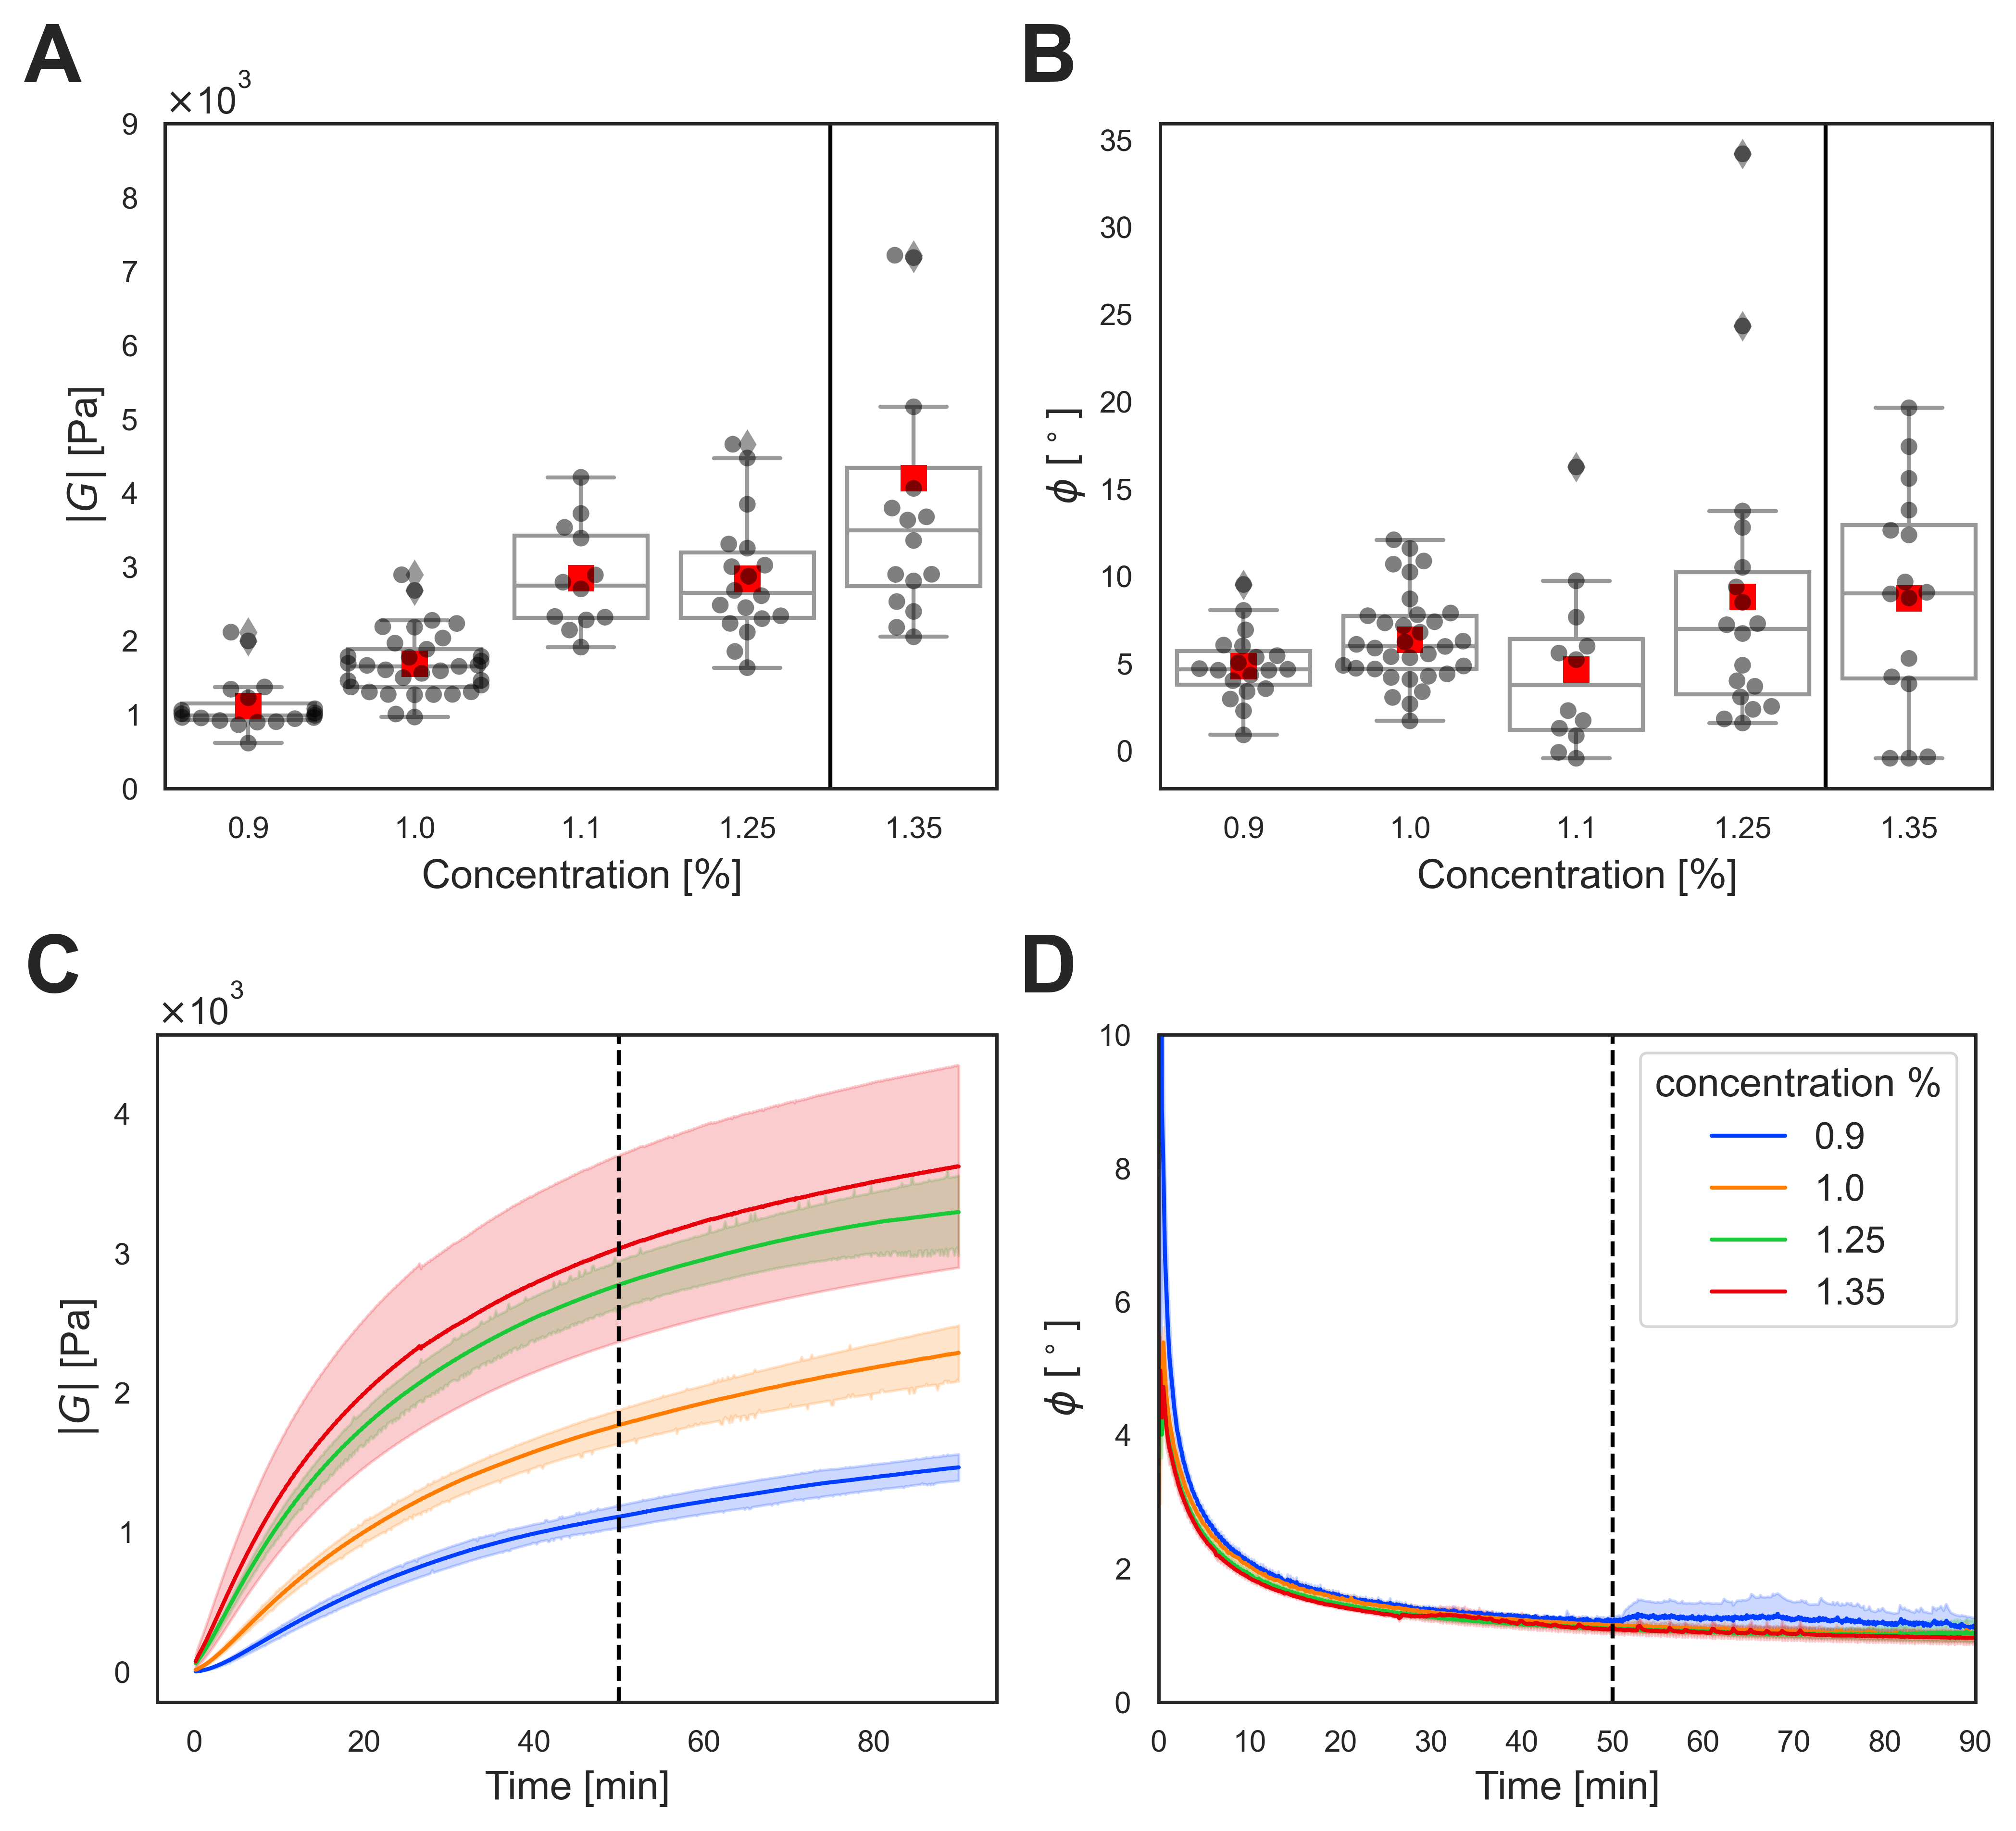

              G_abs              phi_(deg)          
               mean          std      mean       std
sample                                              
0.90    1118.092031   372.495170  4.847353  1.977577
1.00    1688.868938   438.830303  6.344201  2.592010
1.10    2852.340499   716.645595  4.658428  4.869317
1.25    2840.969704   828.101760  8.798625  8.464983
1.35    4202.041381  2475.192115  8.738779  6.343791


<ipython-input-10-108b88866807>:23: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print(Agarose.groupby("sample")["G_abs","phi_(deg)"].agg(["mean","std"]))


In [10]:
#Agarose 100µm microrheology

fig = plt.figure(constrained_layout=True, figsize=(8.27, 7.5),dpi = 500)
subfigs = fig.subfigures(2, 2, wspace=0.0025, width_ratios=[1, 1])

ax1 = subfigs[0,0].subplots(1, 1)
ax2 = subfigs[0,1].subplots(1, 1)
ax3 = subfigs[1,0].subplots(1, 1)
ax4 = subfigs[1,1].subplots(1, 1)

#Agarose macrorheology 

ax1 = plotter(Agarose, "sample", "G_abs",r"Concentration [$\%$]",r'$|G|$ [Pa]',ax1,"A",True)
ax1.axvline(3.5,color='black',linestyle='-')
ax1.set_ylim([0,9e3])
ax2 = plotter(Agarose, "sample", "phi_(deg)",r"Concentration [$\%$]",r"$\phi$ $[^\circ]$",ax2,"B")
ax2.axvline(3.5,color='black',linestyle='-')
ax3 = plot_macro_g(M_Ag,ax3,"C","Time [min]","$|G|$ [Pa]",vline=True,log=True)
ax4 = plot_macro_phi(M_Ag,ax4,"D","Time [min]",r"$\phi$ $[^\circ]$",vline=True,log=False, ae = True)
saver(fig,"high_stiffness.png")
plt.show()

print(Agarose.groupby("sample")["G_abs","phi_(deg)"].agg(["mean","std"]))

c:\Users\lehtona6\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 8.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\lehtona6\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 38.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\lehtona6\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 19.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\lehtona6\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 22.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


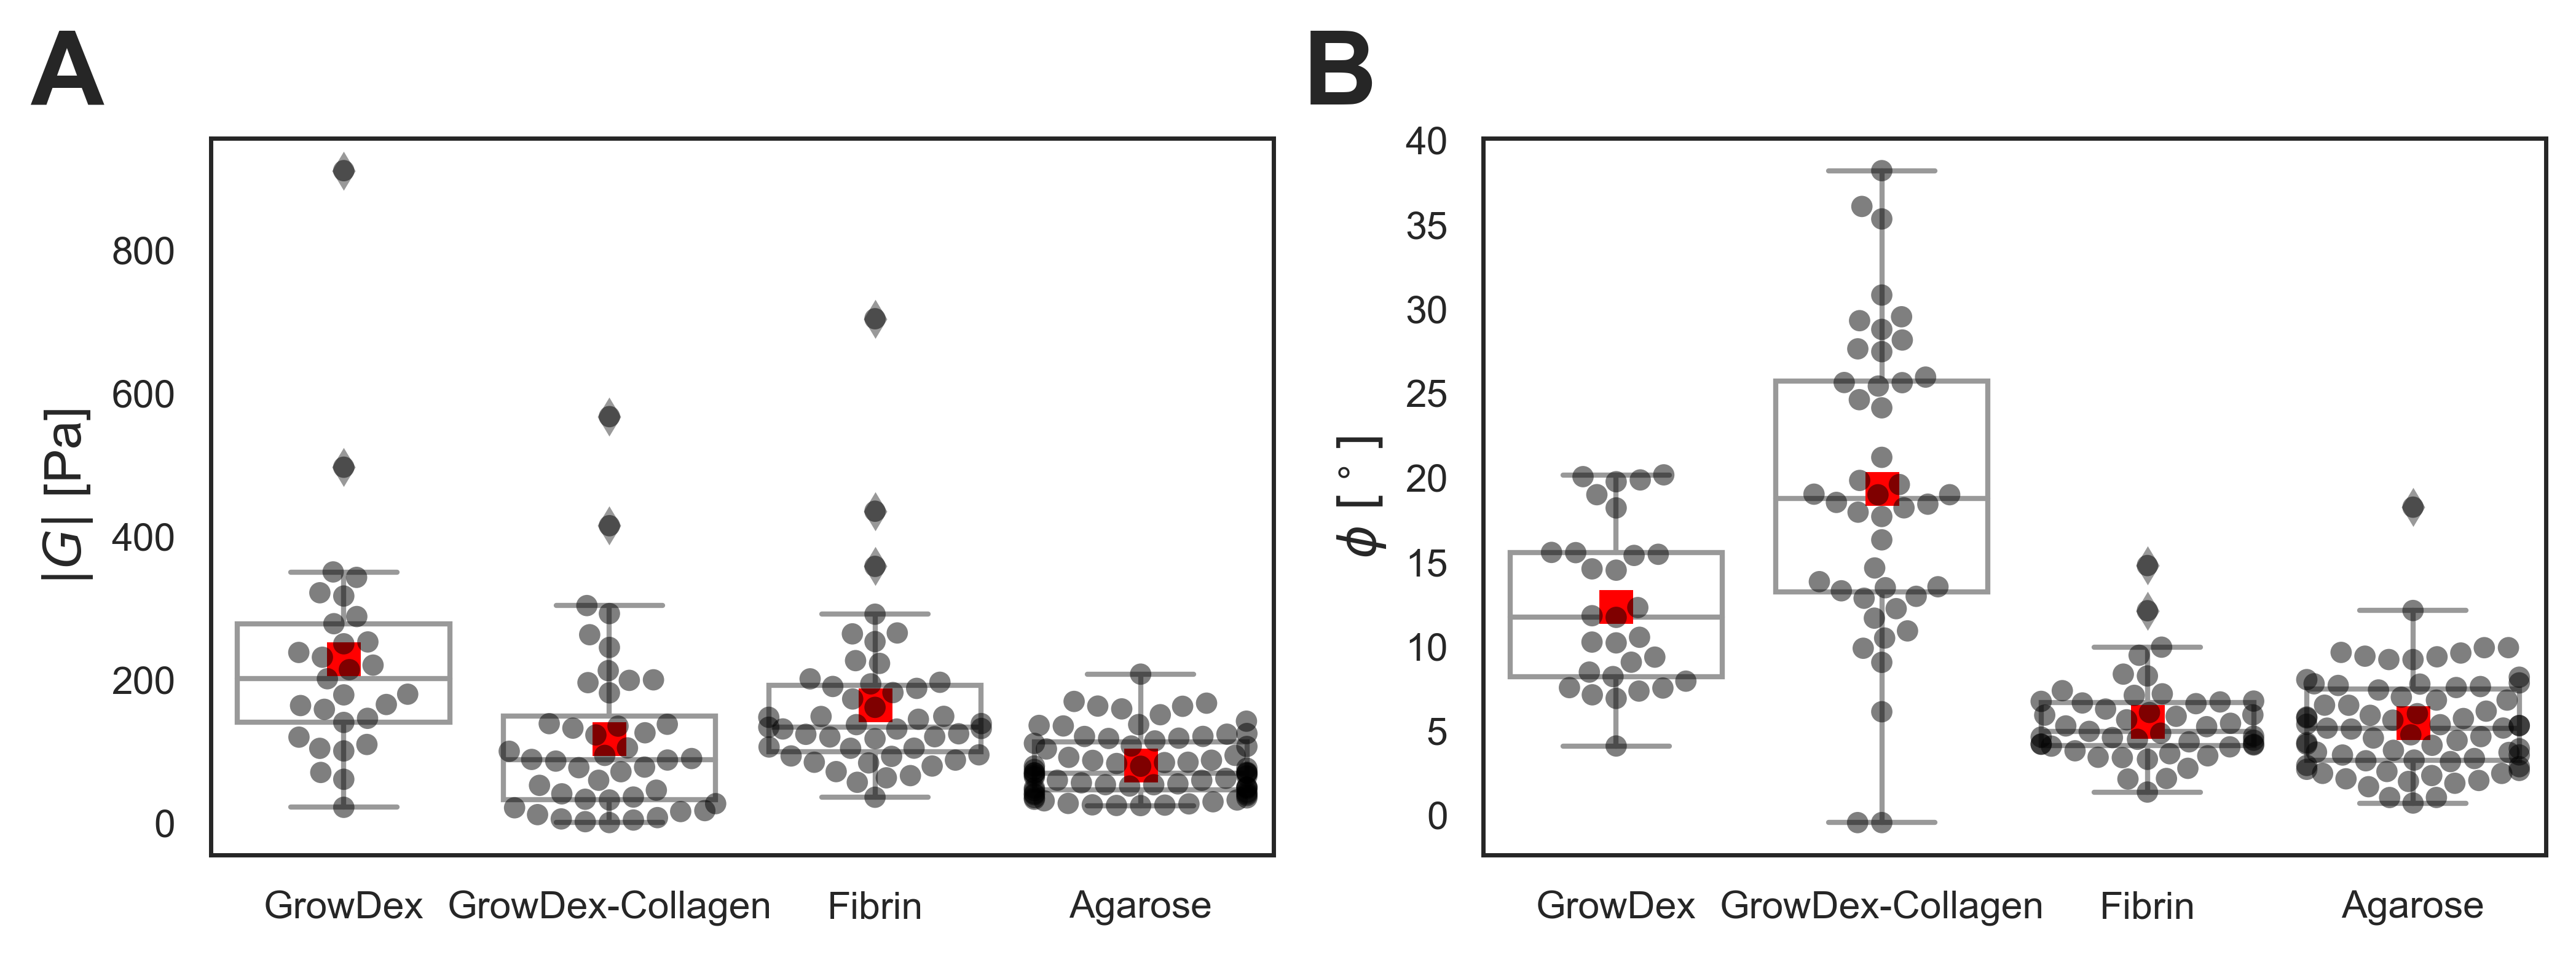

                       G_abs              phi_(deg)          
                        mean         std       mean       std
type                                                         
Agarose            80.578980   43.968305   5.458549  3.006753
Fibrin            164.652427  112.568050   5.550984  2.497439
GrowDex           228.883951  166.511160  12.359034  4.780554
GrowDex-Collagen  117.349123  117.233180  19.347722  8.905707


<ipython-input-11-433d197234dc>:15: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print(hetero_gen.groupby("type")["G_abs","phi_(deg)"].agg(["mean","std"]))


In [11]:
#Heterogenity quantification |G| ja \phi

fig = plt.figure(constrained_layout=True,figsize=(8.27, 3),dpi = 500)
subfigs = fig.subfigures(1, 2, wspace=0.0025, width_ratios=[1, 1])

ax1 = subfigs[0].subplots(1, 1)
ax2 = subfigs[1].subplots(1, 1)
ax1 = plotter(hetero_gen, "type", "G_abs",r"",r'$|G|$ [Pa]',ax1,"A")
ax2 = plotter(hetero_gen, "type", "phi_(deg)",r"",r"$\phi$ $[^\circ]$",ax2,"B",False,False)
saver(fig,"hetero_abs.png")
plt.show()

print(hetero_gen.groupby("type")["G_abs","phi_(deg)"].agg(["mean","std"]))


In [12]:
##Supplementary table

Agarose_mm = Agarose
Agarose_mm["type"] = 0
hetero_gen.loc[hetero_gen["type"]=="Agarose","type"] = "Agarose 0.5%"
Agarose_mm.loc[Agarose_mm["sample"]==0.9,"type"] = "Agarose 0.9%"
Agarose_mm.loc[Agarose_mm["sample"]==1.0,"type"] = "Agarose 1.0%"
Agarose_mm.loc[Agarose_mm["sample"]==1.1,"type"] = "Agarose 1.1%"
Agarose_mm.loc[Agarose_mm["sample"]==1.25,"type"] = "Agarose 1.25%"
Agarose_mm.loc[Agarose_mm["sample"]==1.35,"type"] = "Agarose 1.35%"
table = pd.concat([hetero_gen,Agarose_mm])
table_mm = table.groupby("type")["G_abs","phi_(deg)"].agg(["mean","std"])
table_mm.reset_index()

table_mm.reset_index()
print(table_mm.to_latex(index=True)) 

<ipython-input-12-9375472595b1>:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  table_mm = table.groupby("type")["G_abs","phi_(deg)"].agg(["mean","std"])


\begin{tabular}{lrrrr}
\toprule
{} & \multicolumn{2}{l}{G\_abs} & \multicolumn{2}{l}{phi\_(deg)} \\
{} &         mean &          std &       mean &       std \\
type             &              &              &            &           \\
\midrule
Agarose 0.5\%     &    80.578980 &    43.968305 &   5.458549 &  3.006753 \\
Agarose 0.9\%     &  1118.092031 &   372.495170 &   4.847353 &  1.977577 \\
Agarose 1.0\%     &  1688.868938 &   438.830303 &   6.344201 &  2.592010 \\
Agarose 1.1\%     &  2852.340499 &   716.645595 &   4.658428 &  4.869317 \\
Agarose 1.25\%    &  2840.969704 &   828.101760 &   8.798625 &  8.464983 \\
Agarose 1.35\%    &  4202.041381 &  2475.192115 &   8.738779 &  6.343791 \\
Fibrin           &   164.652427 &   112.568050 &   5.550984 &  2.497439 \\
GrowDex          &   228.883951 &   166.511160 &  12.359034 &  4.780554 \\
GrowDex-Collagen &   117.349123 &   117.233180 &  19.347722 &  8.905707 \\
\bottomrule
\end{tabular}



<ipython-input-12-9375472595b1>:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table_mm.to_latex(index=True))


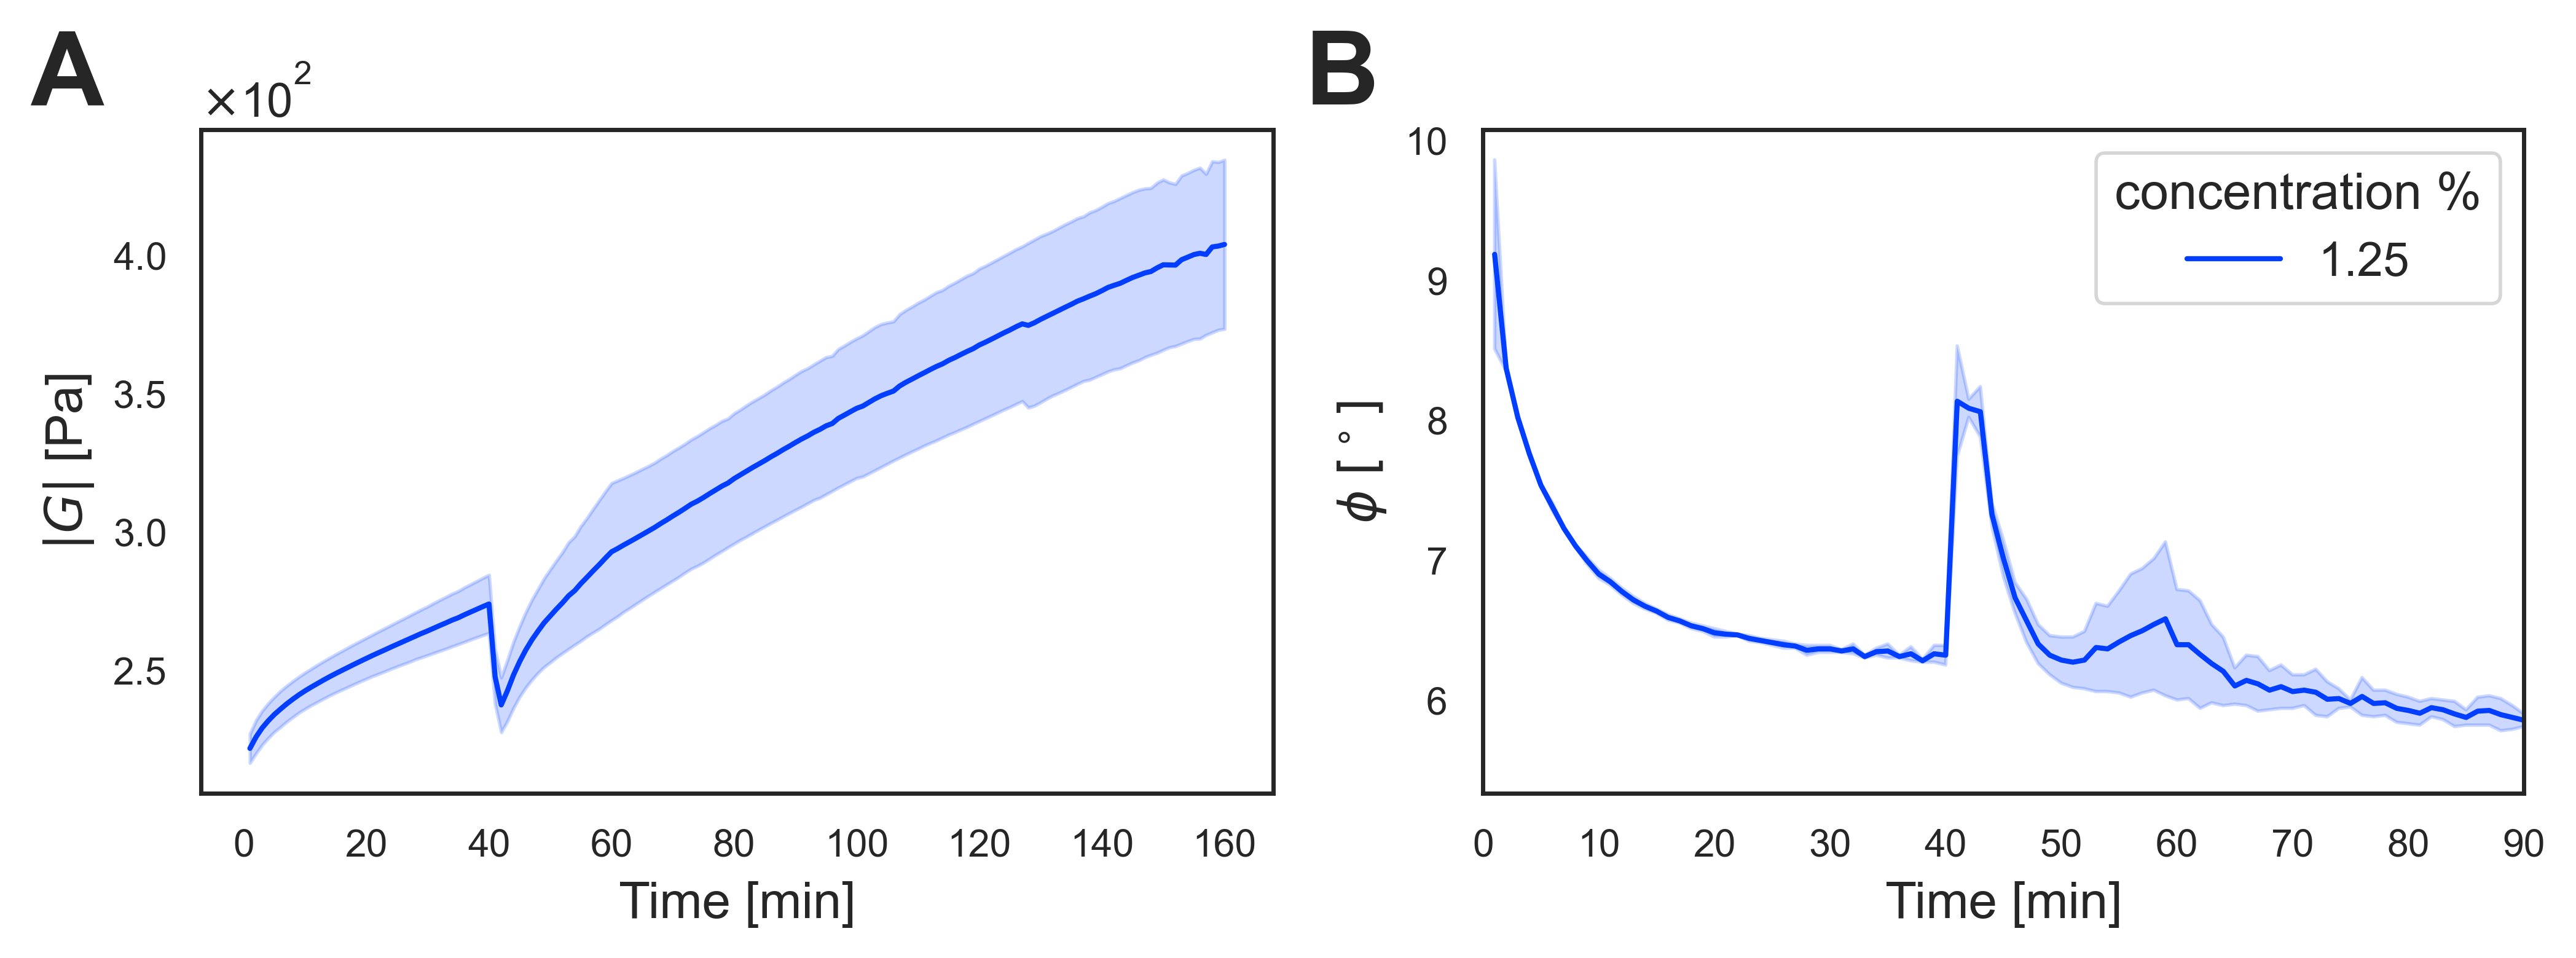

In [13]:
# GrowDex macrorheology, not part of the article

fig = plt.figure(constrained_layout=True, figsize=(8.27, 3),dpi = 500)
subfigs = fig.subfigures(1, 2, wspace=0.0025, width_ratios=[1, 1])

ax1 = subfigs[0].subplots(1, 1)
ax2 = subfigs[1].subplots(1, 1)

#plot_macro_g(M_GD,"MD_g.png", 8.3/1.5,11.7/3,"Time [min]","Absolute Shear Modulus [Pa]",vline=True,log=True)
#plot_macro_phi(M_GD,"MD_phi.png", 8.3/1.5,11.7/3,"Time [min]","Loss Tangent []",vline=True,log=False)

ax1 = plot_macro_g(M_GD,ax1,"A","Time [min]","$|G|$ [Pa]",vline=False,log=True)
ax2 = plot_macro_phi(M_GD,ax2,"B","Time [min]",r"$\phi$ $[^\circ]$",vline=False,log=False, ae = False)


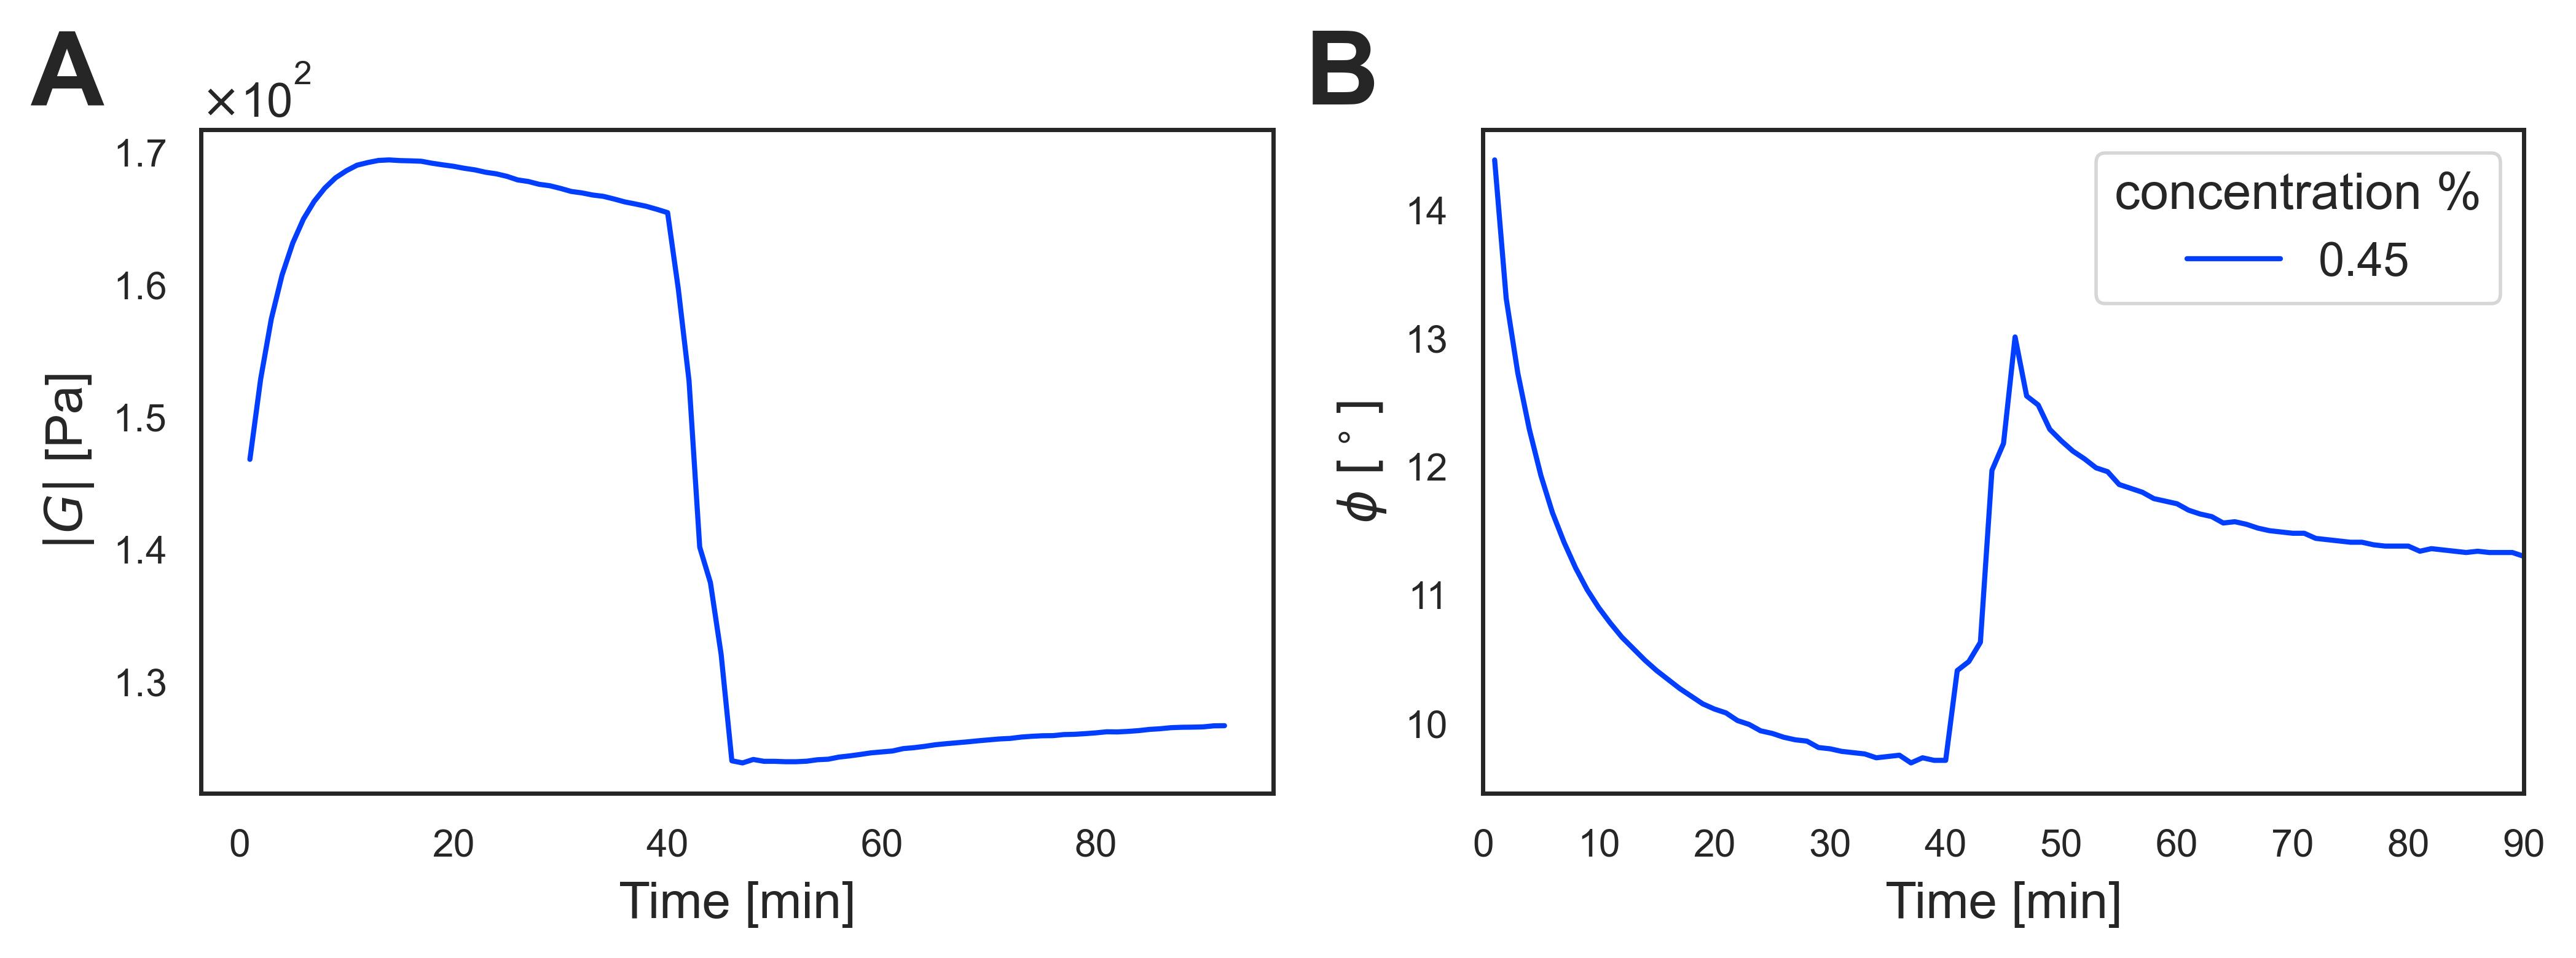

In [14]:
# Growdex-Collagen macrorheology, not part of the article 

fig = plt.figure(constrained_layout=True, figsize=(8.27, 3),dpi = 500)
subfigs = fig.subfigures(1, 2, wspace=0.0025, width_ratios=[1, 1])


ax1 = subfigs[0].subplots(1, 1)
ax2 = subfigs[1].subplots(1, 1)


ax1 = plot_macro_g(M_GD_col,ax1,"A","Time [min]","$|G|$ [Pa]",vline=False,log=True)
ax2 = plot_macro_phi(M_GD_col,ax2,"B","Time [min]",r"$\phi$ $[^\circ]$",vline=False,log=False, ae = False)



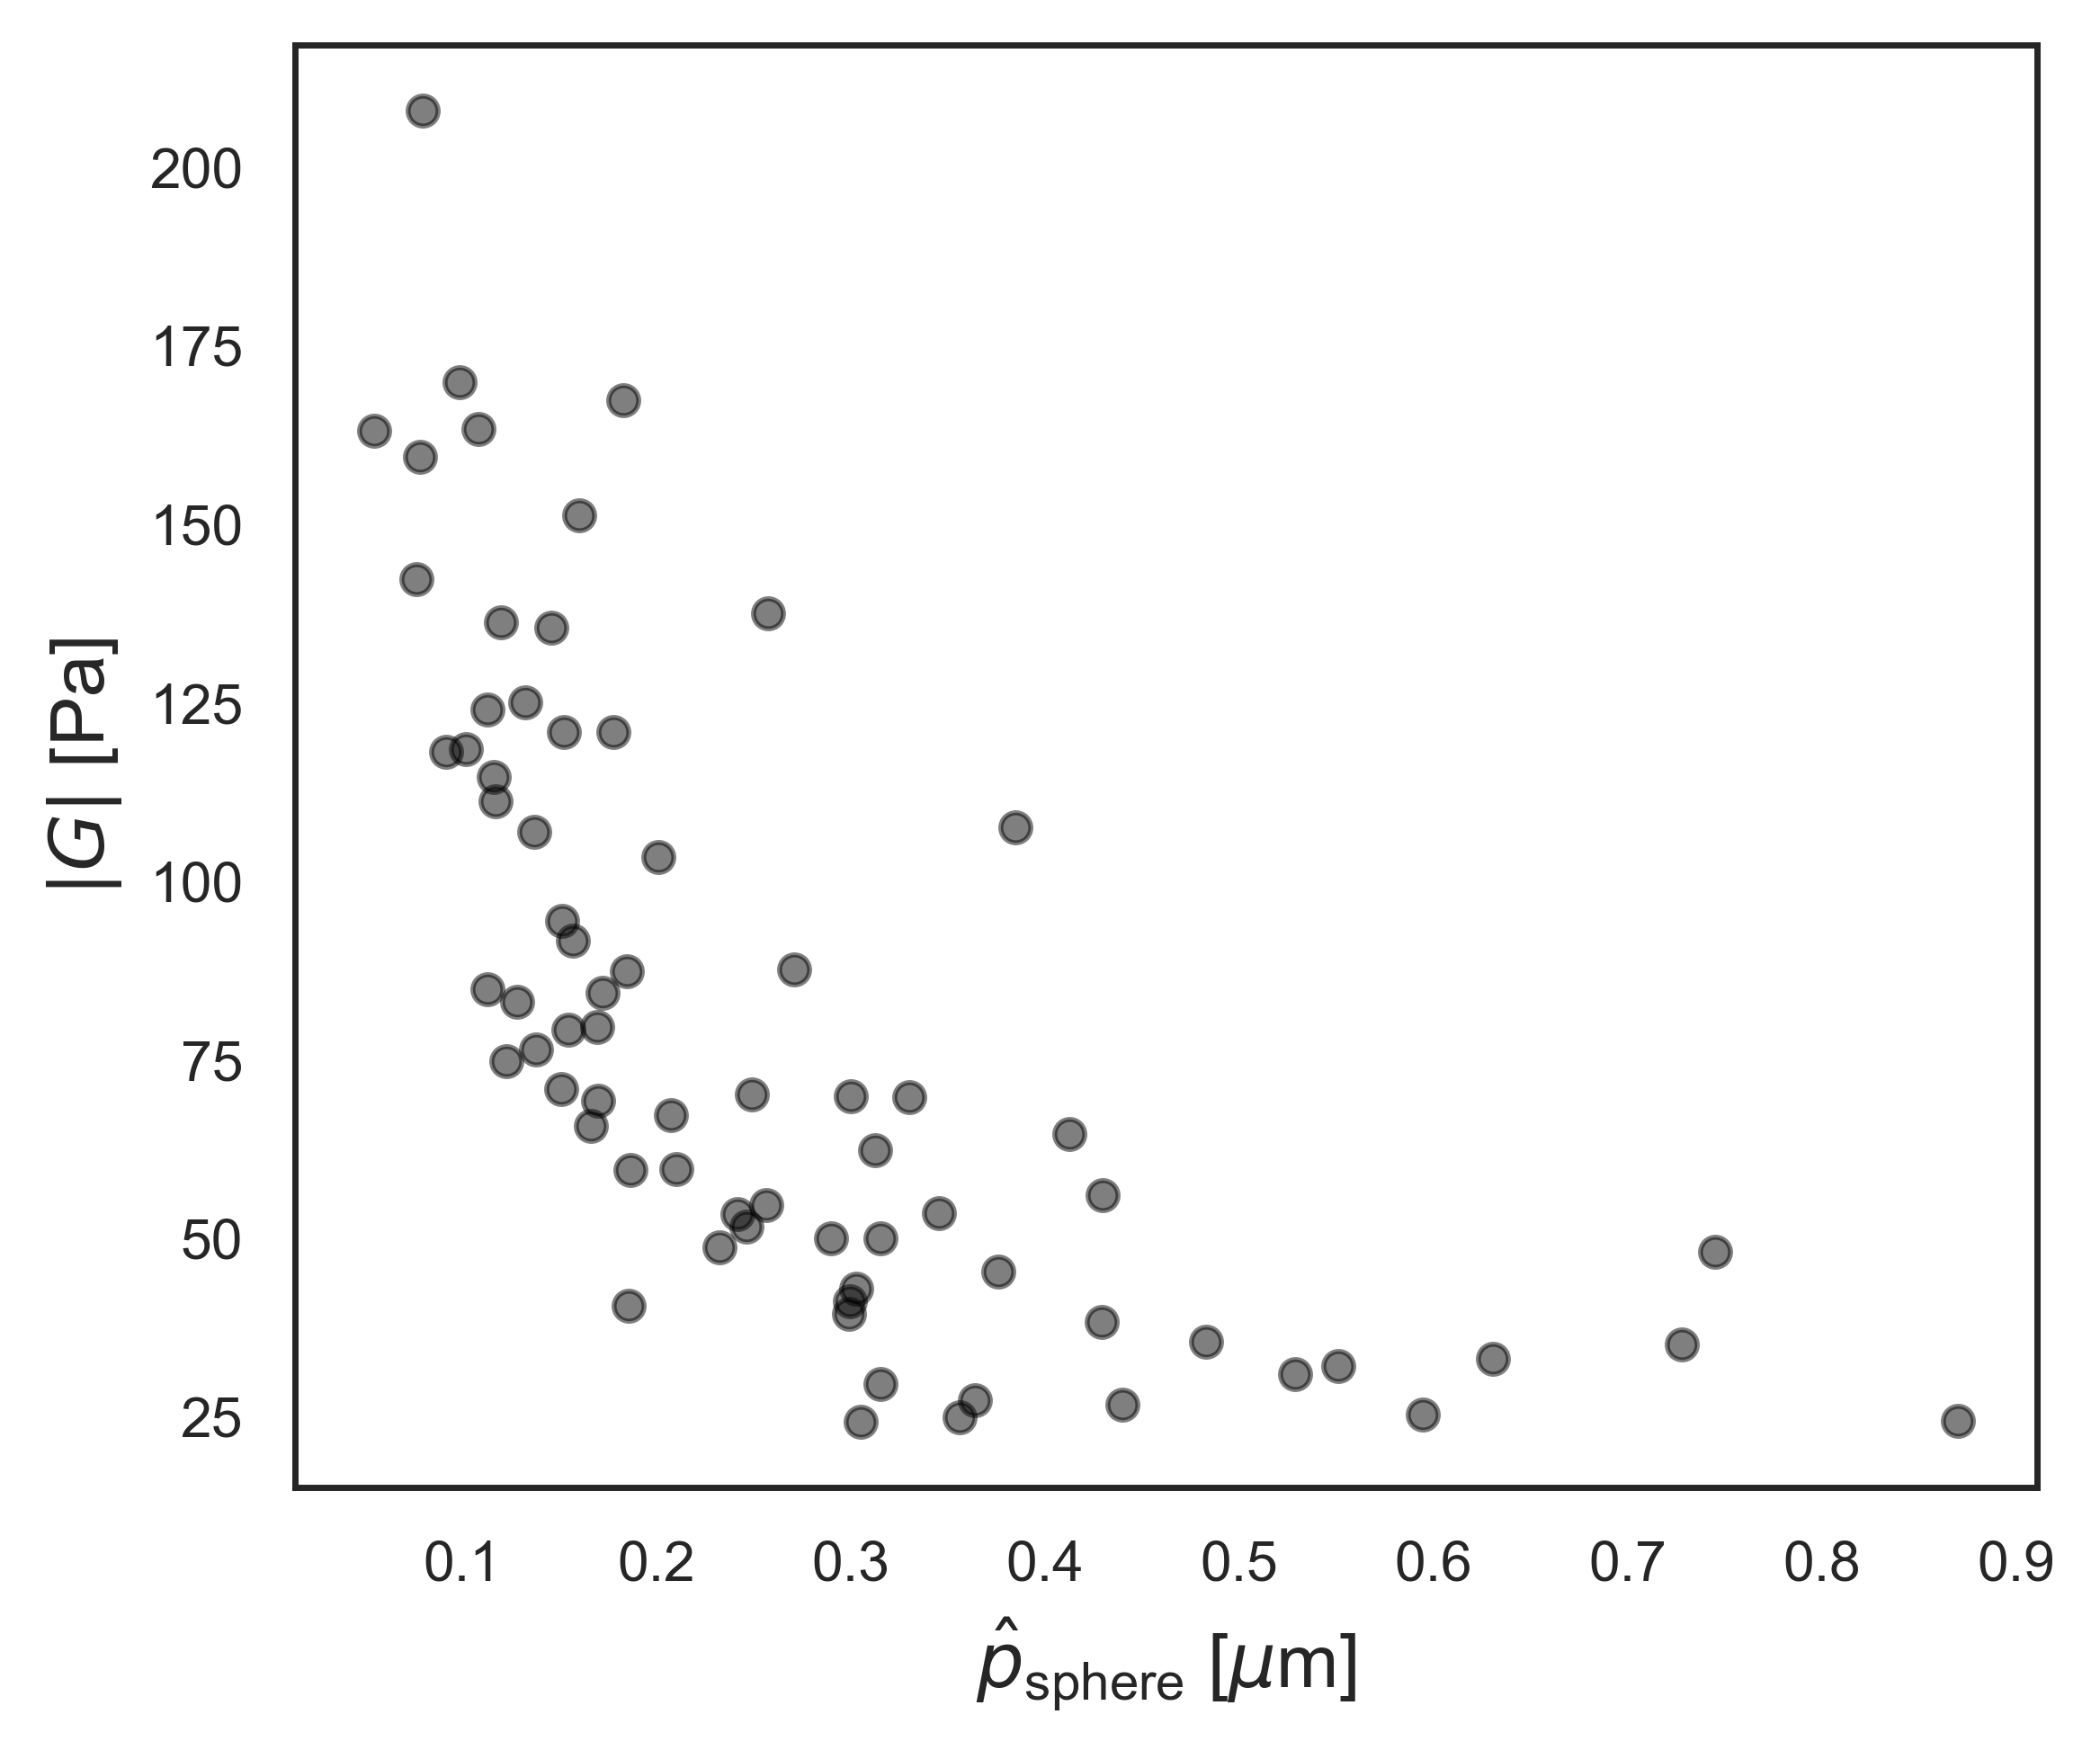

In [15]:
##supplementary |G|(\hat{p})

fig = plt.figure( figsize=(5, 4.25),dpi = 500)
plt.scatter(y= low_Agarose["G_abs"],x=low_Agarose["a_(um)"],color='black',alpha=0.5)
plt.ylabel(r'$|G|$ [Pa]', fontsize=12)
plt.xlabel(r"$\hat{p}_\mathregular{sphere}$ [$\mu$m]", fontsize=12)
plt.tick_params(labelsize=9)

saver(fig,"disps_vs_G.png")

plt.show()


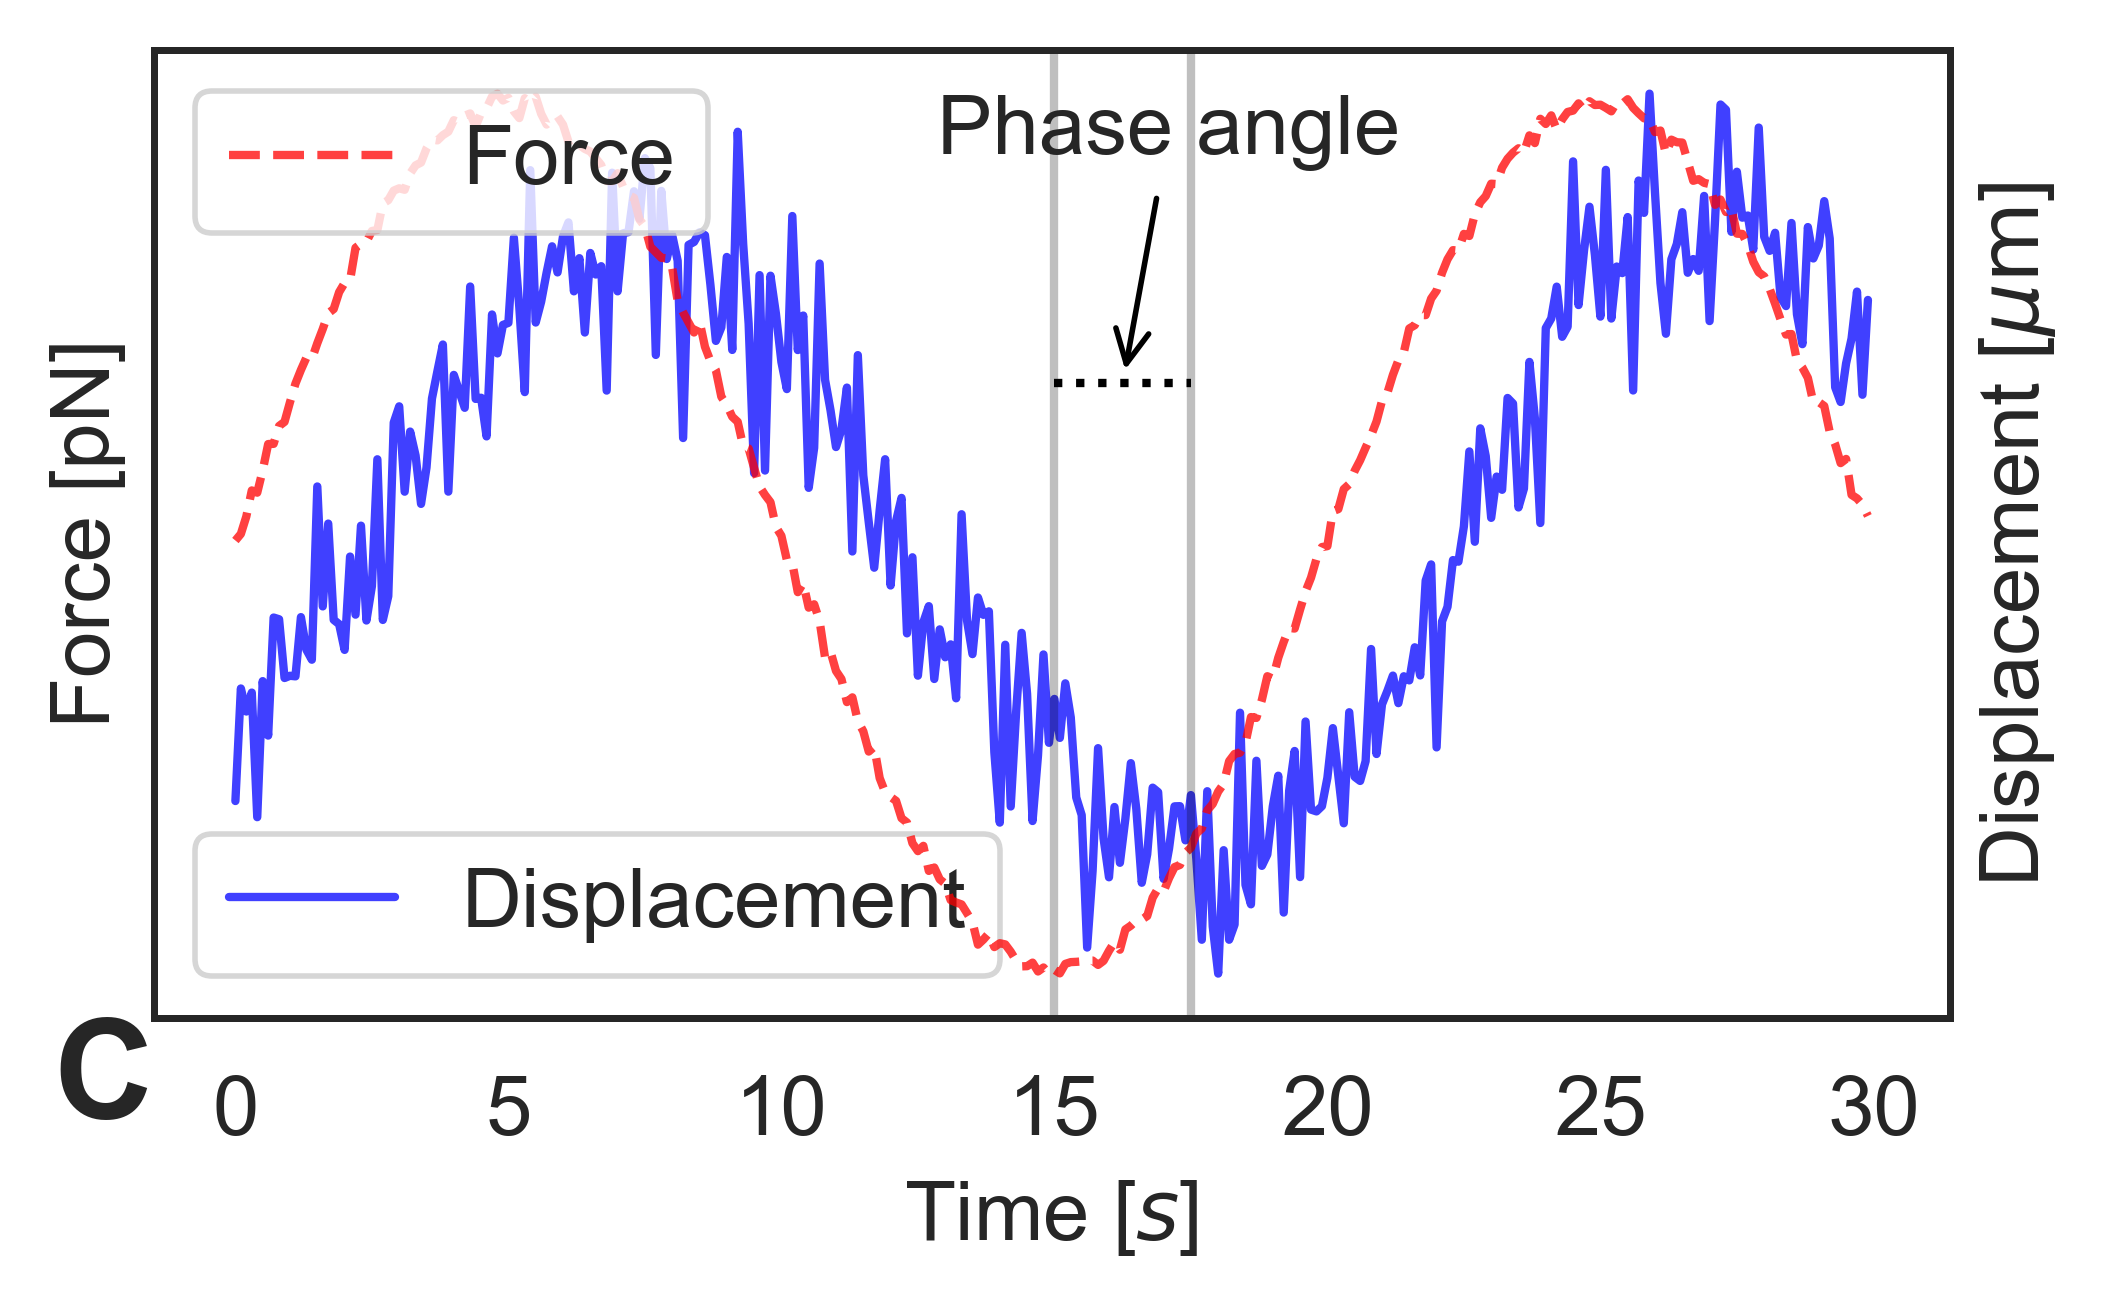

In [6]:
amplitude = 0.5
phase = -0.4
f=0.05
t=np.arange(-1,29,1e-1)
t2=np.arange(0,30,1e-1)
error =np.random.normal(0, 0.1,len(t))
error_2 =np.random.normal(0, 0.0075,len(t2))
displacment = amplitude*np.sin(2*np.pi*f*t+phase)+error
current = amplitude*np.sin(2*np.pi*f*t2)+error_2

fig, ax1 = plt.subplots(constrained_layout=True, figsize=(4.1, 2.5),dpi = 500)

ax1.set_xlabel(r"time [s]", fontsize=12)
ax1.set_ylabel(r"Force [pN]", fontsize=12)
ax1.tick_params(labelsize=12)
ax1.text(0, 0, "C", transform=ax1.transAxes,fontsize=20, fontweight='bold', va='top', ha='right')
ax2_twin = ax1.twinx()
ax1.plot(t+np.abs(t[0]),displacment,label = "Displacement", color = "blue",alpha = 0.75)
ax1.axvline(x=15, color = "black",alpha = 0.25)
ax1.hlines(y = 0.25,xmin = 15, xmax = 17.5, colors = "black", linestyle = "dotted")

ax1.annotate(r'Phase angle', xy=(16.25, 0.25), xytext=(12.85, 0.6),fontsize=12,
            arrowprops=dict(arrowstyle="->",color='black'))

ax2_twin.plot(t2,current, label = "Force", color = "red",alpha = 0.75, linestyle = "dashed")
ax1.set_yticks([])
ax2_twin.set_yticks([])
ax1.set_xlabel(r"Time [$s$]", fontsize = 12)
ax2_twin.axvline(x=17.5,color = "black",alpha = 0.25)

ax2_twin.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2_twin.set_xlabel(r"Time [s]", fontsize=12)
ax2_twin.set_ylabel(r"Displacement [$\mu \rm{m}$]", fontsize=12)
ax2_twin.legend(["Force"], loc='upper left',fontsize = 12)
ax1.legend(["Displacement"], loc='lower left',fontsize = 12)
ax2_twin.tick_params(labelsize=12)
saver(fig,"test_2.png")